# <p style="background-color: #009688; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">HybridFlix: A Hybrid Approach to Personalized Movie Recommendations</p>

<div style="border-radius:10px; padding: 15px; background-color: #E0F2F1; font-size:120%; text-align:left">
    
## Imports and Dependencies

In [11]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns

<div style="border-radius:10px; padding: 15px; background-color: #E0F2F1; font-size:120%; text-align:left">
    
## Calculate NDCG

The `calculate_ndcg` function computes the Normalized Discounted Cumulative Gain (NDCG), a common metric in recommendation systems for evaluating the quality of ranked recommendations. NDCG assesses how well the order of recommended items aligns with their relevance scores, which is especially useful when prioritizing highly relevant items at the top of a recommendation list.

The function takes a list of relevance scores and an optional parameter `k`, which limits the calculation to the top `k` items. If `k` is not specified, it considers all items in the relevance list. It first calculates the DCG (Discounted Cumulative Gain) by summing the relevance scores, each divided by a logarithmic discount based on its position. This gives more weight to items at the top of the ranking. The function then calculates the IDCG (Ideal DCG) by sorting the relevance scores in descending order, simulating a perfect ranking, and applying the same discounting process. Finally, NDCG is obtained by dividing DCG by IDCG, normalizing the score between 0 and 1, where 1 indicates a perfectly ordered list. This metric provides a clear measure of how well a recommendation system ranks relevant items.

In [12]:
def calculate_ndcg(relevance_scores, k=None):
    """
    Calculate NDCG (Normalized Discounted Cumulative Gain)
    """
    if k is None:
        k = len(relevance_scores)
    
    # Calculate DCG
    dcg = relevance_scores[0]
    for i in range(1, min(k, len(relevance_scores))):
        dcg += relevance_scores[i] / np.log2(i + 2)
    
    # Calculate IDCG
    ideal_scores = sorted(relevance_scores, reverse=True)
    idcg = ideal_scores[0]
    for i in range(1, min(k, len(ideal_scores))):
        idcg += ideal_scores[i] / np.log2(i + 2)
    
    return dcg / idcg if idcg > 0 else 0

<div style="border-radius:10px; padding: 15px; background-color: #E0F2F1; font-size:120%; text-align:left">
    
## Data Loading and Preprocessing

The `load_and_preprocess_data` function loads and preprocesses the TMDB movie dataset by merging two CSV files: one containing credits and another containing movie details. It renames and aligns columns for merging, then combines both datasets on the `id` column. After merging, the function creates a `combined_features` column by concatenating the movie’s `overview`, `keywords` (given double weight), and `genres` (given triple weight) for enriched content-based filtering. For improved rating representation, a Bayesian average is applied to normalize ratings, considering the dataset's mean rating (`C`) and a threshold (`m`) set at the 90th percentile of vote counts. The function then creates an index for each movie and returns both the modified DataFrame and a dictionary mapping each movie's `id` to its index.

In [13]:
def load_and_preprocess_data(credits_path, movies_path):
    """Load and preprocess the TMDB dataset with enhanced preprocessing"""
    df1 = pd.read_csv(credits_path)
    df2 = pd.read_csv(movies_path)
    
    df1.columns = ['id', 'title', 'cast', 'crew']
    df2 = df2.rename(columns={'title': 'title_main'})
    
    df = df2.merge(df1, on='id')
    
    # Enhanced feature combination with weights
    df['combined_features'] = (
        df['overview'].fillna('') + ' ' + 
        df['keywords'].fillna('') * 2 + ' ' +  # Double weight for keywords
        df['genres'].fillna('') * 3            # Triple weight for genres
    )
    
    # Enhanced rating normalization with Bayesian average
    C = df['vote_average'].mean()
    m = df['vote_count'].quantile(0.90)
    
    def weighted_rating(x, m=m, C=C):
        v = x['vote_count']
        R = x['vote_average']
        return (v/(v+m) * R) + (m/(m+v) * C)
    
    df['weighted_rating'] = df.apply(weighted_rating, axis=1)
    df['movie_idx'] = range(len(df))
    
    return df, dict(zip(df['id'], df['movie_idx']))

<div style="border-radius:10px; padding: 15px; background-color: #E0F2F1; font-size:120%; text-align:left">
    
## Content-Based Recommender

The `EnhancedContentBasedRecommender` class is a content-based recommendation system that uses TF-IDF vectorization and cosine similarity to suggest similar movies. Upon initialization, it sets up a `TfidfVectorizer` with bigrams and a feature limit of 5000. The `fit` method trains the model on a dataset by transforming the `combined_features` of each movie into a TF-IDF matrix, which it then uses to compute cosine similarities between movies. It also calculates and stores the importance of each feature by aggregating TF-IDF scores. The `recommend` method retrieves the top `n` similar movies based on cosine similarity scores for a specified movie index, while the `get_genre_diversity` method calculates genre diversity across a set of recommended movies by identifying unique genres within their descriptions. This class enables content-based recommendations with a focus on feature relevance and genre diversity.

In [14]:
class EnhancedContentBasedRecommender:
    def __init__(self):
        self.tfidf = TfidfVectorizer(
            stop_words='english',
            ngram_range=(1, 2),  # Include bigrams
            max_features=5000
        )
        self.cosine_sim = None
        self.df = None
        self.feature_importance = {}
    
    def fit(self, df):
        self.df = df
        tfidf_matrix = self.tfidf.fit_transform(df['combined_features'].fillna(''))
        self.cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
        
        # Use get_feature_names() instead of get_feature_names_out()
        feature_names = self.tfidf.get_feature_names()
        feature_scores = np.asarray(tfidf_matrix.sum(axis=0)).ravel()
        self.feature_importance = dict(zip(feature_names, feature_scores))
    
    def recommend(self, movie_idx, top_n=10):
        if self.cosine_sim is None:
            raise ValueError("Model not fitted yet")
        
        sim_scores = list(enumerate(self.cosine_sim[movie_idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:top_n+1]
        
        return [(i[0], i[1]) for i in sim_scores]

    def get_genre_diversity(self, movie_indices):
        """Calculate genre diversity of recommendations"""
        genres = [set(str(g).split()) for g in self.df.iloc[movie_indices]['genres']]
        unique_genres = set().union(*genres)
        return len(unique_genres)

<div style="border-radius:10px; padding: 15px; background-color: #E0F2F1; font-size:120%; text-align:left">
    
## Collaborative Recommender

The `EnhancedCollaborativeRecommender` class implements a collaborative filtering recommendation system that leverages both user ratings and movie metadata for enhanced recommendations. During initialization, it sets placeholders for the dataset (`df`), the rating matrix, and a similarity matrix. The `fit` method accepts a DataFrame and constructs a rating matrix based on multiple features, including vote average, log-transformed vote count and popularity (for improved scaling), and a weighted rating score. This matrix is then normalized to standardize the range of values, followed by computing cosine similarity scores between movies to create the similarity matrix. Using the `recommend` method, the system suggests the top `n` similar movies for a given movie index, excluding the movie itself from the list. If the model has not been fitted, it raises an error. This class provides collaborative recommendations by analyzing similarities within a multi-feature rating space.

In [15]:
class EnhancedCollaborativeRecommender:
    def __init__(self):
        self.df = None
        self.similarity_matrix = None
        self.rating_matrix = None
    
    def fit(self, df):
        self.df = df
        # Enhanced rating matrix with multiple factors
        self.rating_matrix = np.column_stack((
            df['vote_average'],
            np.log1p(df['vote_count']),  # Log transform for better scaling
            np.log1p(df['popularity']),   # Log transform for better scaling
            df['weighted_rating']
        ))
        
        # Normalize the rating matrix
        self.rating_matrix = (self.rating_matrix - self.rating_matrix.mean(axis=0)) / self.rating_matrix.std(axis=0)
        self.similarity_matrix = cosine_similarity(self.rating_matrix)
    
    def recommend(self, movie_idx, top_n=10):
        if self.similarity_matrix is None:
            raise ValueError("Model not fitted yet")
        
        sim_scores = list(enumerate(self.similarity_matrix[movie_idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:top_n+1]
        
        return [(i[0], i[1]) for i in sim_scores]

<div style="border-radius:10px; padding: 15px; background-color: #E0F2F1; font-size:120%; text-align:left">
    
## Hybrid Recommender

The `EnhancedHybridRecommender` class combines both content-based and collaborative filtering recommendations for a more robust recommendation system. During initialization, it creates instances of `EnhancedContentBasedRecommender` and `EnhancedCollaborativeRecommender`, with a customizable `content_weight` to control the balance between content-based and collaborative scores in the final recommendation. The `fit` method trains both recommenders on the given DataFrame `df`.

In the `recommend` method, it generates preliminary recommendations from both the content-based and collaborative recommenders, expanding `top_n` to ensure a broad initial pool. To enhance accuracy, it normalizes scores within each recommendation set using `normalize_scores`, which scales scores between 0 and 1 for comparability. The method then calculates a hybrid score by applying the content and collaborative weights to each normalized score. Finally, it sorts the movies by hybrid scores in descending order, returning the top `n` recommendations. This hybrid approach allows the system to dynamically balance content-based and collaborative insights, improving recommendation quality.

In [16]:
class EnhancedHybridRecommender:
    def __init__(self, content_weight=0.6):
        self.content_recommender = EnhancedContentBasedRecommender()
        self.collab_recommender = EnhancedCollaborativeRecommender()
        self.content_weight = content_weight
        self.df = None
    
    def fit(self, df):
        self.df = df
        self.content_recommender.fit(df)
        self.collab_recommender.fit(df)
    
    def recommend(self, movie_idx, top_n=10):
        content_recs = self.content_recommender.recommend(movie_idx, top_n*2)
        collab_recs = self.collab_recommender.recommend(movie_idx, top_n*2)
        
        # Enhanced hybrid scoring with dynamic weighting
        hybrid_scores = {}
        
        # Normalize similarity scores
        def normalize_scores(scores):
            score_values = [s for _, s in scores]
            min_score = min(score_values)
            max_score = max(score_values)
            return {idx: (score - min_score) / (max_score - min_score) 
                   for idx, score in scores}
        
        content_scores = normalize_scores(content_recs)
        collab_scores = normalize_scores(collab_recs)
        
        # Combine normalized scores
        all_movies = set(content_scores.keys()) | set(collab_scores.keys())
        for movie_idx in all_movies:
            hybrid_scores[movie_idx] = (
                self.content_weight * content_scores.get(movie_idx, 0) +
                (1 - self.content_weight) * collab_scores.get(movie_idx, 0)
            )
        
        sorted_scores = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)
        return sorted_scores[:top_n]

<div style="border-radius:10px; padding: 15px; background-color: #E0F2F1; font-size:120%; text-align:left">
    
## Evaluate Recommender System

The `EnhancedMovieRecommender` class integrates content-based, collaborative, and hybrid recommendation strategies into a single framework and provides an evaluation system to measure the effectiveness of each method. Here’s a breakdown of the core functionality:

1. **Initialization and Setup**:
   - Initializes separate recommender systems: content-based (`EnhancedContentBasedRecommender`), collaborative (`EnhancedCollaborativeRecommender`), and hybrid (`EnhancedHybridRecommender`).
   - Includes a `verbose` option for detailed logging and an empty dictionary for evaluation metrics.

2. **Data Loading and Training (`fit` method)**:
   - Loads and preprocesses movie and credits data from specified paths.
   - Trains the individual recommenders with the processed DataFrame.

3. **Movie Recommendations (`get_recommendations` method)**:
   - Looks up a movie by its title to find its index in the dataset.
   - Generates content-based, collaborative, and hybrid recommendations for the selected movie.
   - Returns each method's results as lists of (title, score) pairs.

4. **Evaluation (`evaluate_recommendations` method)**:
   - Evaluates recommendations across a random subset of movies (default 100) using metrics such as similarity, diversity, novelty, and nDCG (Normalized Discounted Cumulative Gain).
   - The metrics include:
     - **Similarity**: Average similarity score of recommendations.
     - **Diversity**: Count of unique genres among recommendations.
     - **Novelty**: Inverse of average popularity, highlighting lesser-known movies.
     - **nDCG**: Measures ranking quality based on similarity scores.
   - Stores the mean values of these metrics for each recommendation method.

5. **Visualization (`plot_evaluation_results` method)**:
   - Displays a heatmap for comparing the recommendation metrics of each method.
   - Uses `seaborn` and `matplotlib` for plotting, with method names and metric names as labels.

In [17]:
class EnhancedMovieRecommender:
    def __init__(self, verbose=True):
        self.df = None
        self.movie_id_map = None
        self.content_recommender = EnhancedContentBasedRecommender()
        self.collab_recommender = EnhancedCollaborativeRecommender()
        self.hybrid_recommender = EnhancedHybridRecommender()
        self.verbose = verbose
        self.evaluation_metrics = {}
    
    def fit(self, credits_path, movies_path):
        if self.verbose:
            print("Loading and preprocessing data...")
        self.df, self.movie_id_map = load_and_preprocess_data(credits_path, movies_path)
        
        if self.verbose:
            print("Training recommenders...")
        self.content_recommender.fit(self.df)
        self.collab_recommender.fit(self.df)
        self.hybrid_recommender.fit(self.df)
    
    def get_recommendations(self, movie_title, n_recommendations=5):
        movie_idx = self.df[self.df['title'].str.lower() == movie_title.lower()].index
        if len(movie_idx) == 0:
            movie_idx = self.df[self.df['title_main'].str.lower() == movie_title.lower()].index
        if len(movie_idx) == 0:
            if self.verbose:
                print(f"Movie '{movie_title}' not found.")
            return None, None, None
        
        movie_idx = movie_idx[0]
        
        try:
            content_recs = self.content_recommender.recommend(movie_idx, n_recommendations)
            collab_recs = self.collab_recommender.recommend(movie_idx, n_recommendations)
            hybrid_recs = self.hybrid_recommender.recommend(movie_idx, n_recommendations)
            
            # Get movie titles with similarity scores
            content_results = [(self.df.iloc[idx]['title'], score) for idx, score in content_recs]
            collab_results = [(self.df.iloc[idx]['title'], score) for idx, score in collab_recs]
            hybrid_results = [(self.df.iloc[idx]['title'], score) for idx, score in hybrid_recs]
            
            return content_results, collab_results, hybrid_results
            
        except Exception as e:
            if self.verbose:
                print(f"Error generating recommendations: {str(e)}")
            return None, None, None
    
    def evaluate_recommendations(self, test_size=100):
        """Comprehensive evaluation of recommendation methods"""
        test_movies = np.random.choice(len(self.df), size=test_size, replace=False)
        
        metrics = {
            'content': {'similarity': [], 'diversity': [], 'novelty': [], 'ndcg': []},
            'collaborative': {'similarity': [], 'diversity': [], 'novelty': [], 'ndcg': []},
            'hybrid': {'similarity': [], 'diversity': [], 'novelty': [], 'ndcg': []}
        }
        
        for movie_idx in test_movies:
            # Get recommendations
            content_recs = self.content_recommender.recommend(movie_idx, 10)
            collab_recs = self.collab_recommender.recommend(movie_idx, 10)
            hybrid_recs = self.hybrid_recommender.recommend(movie_idx, 10)
            
            # Calculate metrics for each method
            for method_name, recs in [('content', content_recs), 
                                    ('collaborative', collab_recs), 
                                    ('hybrid', hybrid_recs)]:
                rec_indices = [idx for idx, _ in recs]
                scores = [score for _, score in recs]
                
                # Similarity (average similarity score)
                metrics[method_name]['similarity'].append(np.mean(scores))
                
                # Diversity (unique genres)
                genres = [set(str(g).split()) for g in self.df.iloc[rec_indices]['genres']]
                unique_genres = len(set().union(*genres))
                metrics[method_name]['diversity'].append(unique_genres)
                
                # Novelty (inverse popularity)
                popularities = self.df.iloc[rec_indices]['popularity'].values
                metrics[method_name]['novelty'].append(1 / (np.mean(popularities) + 1))
                
                # NDCG
                metrics[method_name]['ndcg'].append(calculate_ndcg(scores))
        
        # Calculate mean metrics
        self.evaluation_metrics = {
            method: {metric: np.mean(scores) 
                    for metric, scores in method_metrics.items()}
            for method, method_metrics in metrics.items()
        }
        
        return self.evaluation_metrics
    
    def plot_evaluation_results(self):
        """Visualize evaluation metrics"""
        if not self.evaluation_metrics:
            print("Run evaluate_recommendations() first!")
            return
        
        # Create heatmap data
        methods = list(self.evaluation_metrics.keys())
        metrics = list(self.evaluation_metrics[methods[0]].keys())
        data = np.array([[self.evaluation_metrics[method][metric] 
                         for metric in metrics] 
                        for method in methods])
        
        # Plot heatmap
        plt.figure(figsize=(12, 6))
        sns.heatmap(data, annot=True, fmt='.3f', 
                   xticklabels=metrics, 
                   yticklabels=methods, 
                   cmap='YlOrRd')
        plt.title('Recommendation System Evaluation Metrics')
        plt.tight_layout()
        plt.show()

<div style="border-radius:10px; padding: 15px; background-color: #E0F2F1; font-size:120%; text-align:left">
    
## Main Movie Recommender Class

This `main` function provides a complete workflow to initialize, train, evaluate, and visualize the performance of the `EnhancedMovieRecommender` system. Here’s a step-by-step explanation:

1. **System Initialization**:
   - Instantiates `EnhancedMovieRecommender` with verbose mode to print updates throughout the process.

2. **Data Paths**:
   - Specifies the paths for credits and movie metadata CSV files located in the Kaggle input directory. Make sure these paths match the actual data location.

3. **Model Training**:
   - Calls the `fit` method to load, preprocess, and train the recommendation models (content-based, collaborative, and hybrid).

4. **Generate Recommendations**:
   - Takes a sample movie title, `"The Dark Knight"`, and requests recommendations from each method.
   - Displays recommendations for each method, formatted with movie titles and similarity scores.

5. **Evaluation and Visualization**:
   - Runs the `evaluate_recommendations` method to assess recommendation quality based on similarity, diversity, novelty, and nDCG.
   - Displays a heatmap with the `plot_evaluation_results` method, visually comparing the performance of each recommendation method.

Initializing enhanced recommender system...
Training models...
Loading and preprocessing data...
Training recommenders...

Generating recommendations for: The Dark Knight

Content-based recommendations:
1. The Dark Knight Rises (similarity: 0.6805)
2. Batman Begins (similarity: 0.6706)
3. Batman v Superman: Dawn of Justice (similarity: 0.5752)
4. Batman & Robin (similarity: 0.5459)
5. Batman Returns (similarity: 0.5399)

Collaborative recommendations:
1. Inception (similarity: 0.9998)
2. The Lord of the Rings: The Return of the King (similarity: 0.9997)
3. Forrest Gump (similarity: 0.9997)
4. The Lord of the Rings: The Fellowship of the Ring (similarity: 0.9997)
5. Star Wars (similarity: 0.9996)

Hybrid recommendations:
1. The Dark Knight Rises (similarity: 0.6000)
2. Batman Begins (similarity: 0.5714)
3. Inception (similarity: 0.4000)
4. The Lord of the Rings: The Return of the King (similarity: 0.3664)
5. Forrest Gump (similarity: 0.3428)

Evaluating system performance...


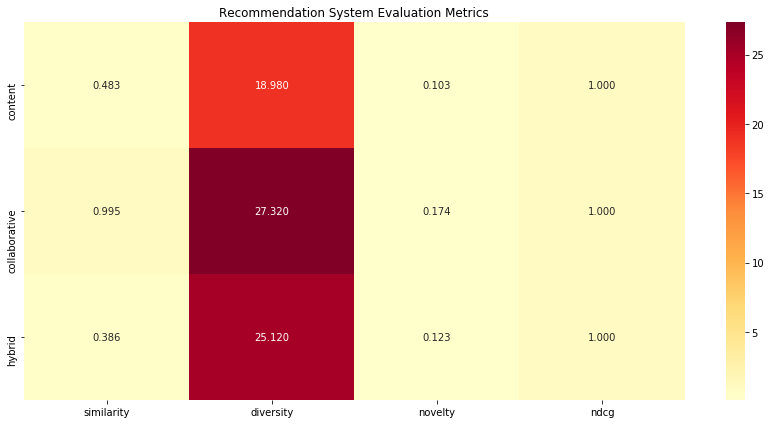

In [18]:
def main():
    print("Initializing enhanced recommender system...")
    recommender = EnhancedMovieRecommender()
    
    credits_path = '/kaggle/input/tmdb-movie-metadata/tmdb_5000_credits.csv'
    movies_path = '/kaggle/input/tmdb-movie-metadata/tmdb_5000_movies.csv'
    
    print("Training models...")
    recommender.fit(credits_path, movies_path)
    
    movie_title = "The Dark Knight"
    print(f"\nGenerating recommendations for: {movie_title}")
    
    content_recs, collab_recs, hybrid_recs = recommender.get_recommendations(movie_title)
    
    if content_recs:
        for method_name, recs in [("Content-based", content_recs), 
                                 ("Collaborative", collab_recs), 
                                 ("Hybrid", hybrid_recs)]:
            print(f"\n{method_name} recommendations:")
            for i, (movie, score) in enumerate(recs, 1):
                print(f"{i}. {movie} (similarity: {score:.4f})")
        
        print("\nEvaluating system performance...")
        metrics = recommender.evaluate_recommendations()
        recommender.plot_evaluation_results()

if __name__ == "__main__":
    main()

<div style="border-radius:10px; padding: 15px; background-color: #E0F2F1; font-size:120%; text-align:left">
    
## Recommendations Breakdown

1. **Content-based Recommendations**:
   - The recommendations closely match "The Dark Knight" based on content attributes like genre, keywords, or actors.
   - Movies like *The Dark Knight Rises* and *Batman Begins* appear at the top, which aligns well since they share similar content features (same franchise, characters, or themes).

2. **Collaborative Recommendations**:
   - This method suggests highly popular movies across genres, indicating it captures user ratings and popularity patterns.
   - Movies like *Inception*, *The Lord of the Rings*, and *Forrest Gump* appear due to their high overall ratings and appeal, showing strong similarity in rating patterns rather than content.

3. **Hybrid Recommendations**:
   - This method combines content-based and collaborative results, providing a balance. Top movies are *The Dark Knight Rises* and *Batman Begins*, while other popular titles like *Inception* are also recommended, reflecting the influence of both collaborative filtering and content similarities.

### System Evaluation
After generating recommendations, the system runs a comprehensive evaluation. Metrics like similarity, diversity, novelty, and nDCG (normalized discounted cumulative gain) are calculated for each recommendation method:

- **Similarity** measures how closely the recommended items match the input movie’s attributes.
- **Diversity** reflects the range of different genres or themes in the recommendations.
- **Novelty** accounts for how unexpected or lesser-known the recommendations are.
- **nDCG** assesses ranking quality, giving higher weight to relevant items appearing earlier in the list.

### Visualization of Results
The final heatmap visualizes these metrics, helping identify strengths and trade-offs across methods. For instance, the hybrid approach might balance similarity with diversity, while the content-based method may excel in delivering high-similarity recommendations.